In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [7]:
def make_df(fnames, time_ahead=30, 
            xlimit=None,ylimit=None, 
            time_steps=10):
    # time_steps is how many steps ahead each sample is taken. E.g. 1 would mean a continuous sliding window
    # Makes a dataframe where each row is a data point containing 
    # - time
    # - current observation
    # - action
    # - next observation
    # - sum of rewards from current : current + time_ahead

    def filter_by_loc(traj,xlimit=1e6,ylimit=0):
        # Quick script to remove wrong points
        locs = np.array(traj['loc'])
        loc = []
        rew = []
        obs = []
        act = []
        t = []
        for i in range(locs.shape[0]):
            if locs[i,0]!=0 and locs[i,1]!=0:
                if locs[i,0]<xlimit and locs[i,1]>ylimit:
                    loc.append(locs[i,:])
                    rew.append(traj['reward'][i])
                    obs.append(traj['obs'][i])
                    t.append(traj['t'][i])
                    act.append(traj['action'][i])
        return np.array(loc),np.array(rew),(np.array(obs)*180).astype(int),np.array(act),np.array(t)
    
    nfiles = len(fnames)
    if xlimit is None:
        xlimit = np.zeros(nfiles) + 1e6
    if ylimit is None:
        ylimit = np.zeros(nfiles)
    
    df = pd.DataFrame(columns=['obs_b','obs_h','action','next_obs_b','next_obs_h','reward','loc'])
    
    # Loops through all points and adds to dataframe
    for f_i,fname in enumerate(fnames):
        with open(fname,'rb') as f:
            traj = pickle.load(f)
        loc,rew,obs,act,t_all = filter_by_loc(traj,xlimit=xlimit[f_i],ylimit=ylimit[f_i])

        for i in np.arange(0, len(t_all)-time_ahead, time_steps):
            df = df.append({
                't':t_all[i],
                'obs_b':obs[i][0],
                'obs_h':obs[i][1],
                'action':act[i],
                'next_obs_b':obs[i+1][0],
                'next_obs_h':obs[i+1][1],
                'reward':sum(rew[i+1:i+1+time_ahead]),
                'loc':loc[i]
                }, ignore_index=True)

    return df

In [48]:
fnames=[
    # First worm
    'Data/traj12-11-2020_19-04-41.pkl', #none
    'Data/traj12-11-2020_19-14-38.pkl', #none
    'Data/traj12-11-2020_19-24-30.pkl', #xlim 800
    # 'Data/traj12-11-2020_19-35-31.pkl', #none # Seems like an especially bad dataset. Actually ruined all the others
    # Second worm
    'Data/traj12-11-2020_19-55-19.pkl', #none
    'Data/traj12-11-2020_20-05-11.pkl', #none
    'Data/traj12-11-2020_20-15-17.pkl', #none
    'Data/traj12-11-2020_20-25-06.pkl', #xlim 1430
]

xlims = [1e6,1e6,800,1e6,1e6,1e6,1430]

traj = make_df(fnames,xlimit=xlims,time_steps=10)

In [43]:
def lin_interp_mat(mat, wraparound=False):
    # Fills in NaNs in matrix by linear interpolation. 
    # Only considers nearest neighbors (no diagonals).
    # Fills in NaNs from most neighbors to least neighbors.
    # wraparound extends matrix in all four directions. Haven't really gotten this to work with edge cases yet.

    def set_range(mat):
        mat[mat<-180] += 360
        mat[mat>=180] -= 360
        return mat

    def get_neighbors(mat,i):
        # Makes array of four neighbors around mat[index]
        # index is a pair
        return np.array([mat[i[0],i[1]-1], mat[i[0],i[1]+1], mat[i[0]-1,i[1]], mat[i[0]+1,i[1]]])

    def make_wraparound(mat,wraparound=False):
        # Expands matrix for wraparound interpolation
        
        mat_new = np.zeros((np.array(mat.shape)+2)) + np.nan
        mat_new[1:-1,1:-1] = mat

        if wraparound:
            mat_new[0,1:-1] = mat[-1,:] 
            mat_new[-1,1:-1] = mat[0,:] 
            mat_new[1:-1,0] = mat[:,-1] 
            mat_new[1:-1,-1] = mat[:,0] 
        return mat_new

    mat = make_wraparound(mat, wraparound=wraparound)

    # Find nans in relevant matrix section
    nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1
        # add 1 because need index for extended matrix
    
    neighbor_lim = 3
    while nan_inds.size>0:
        candidates = 0
        for ind in nan_inds:
            neighbors = get_neighbors(mat,ind)
            if sum(~np.isnan(neighbors)) >= neighbor_lim:
                mat[ind[0],ind[1]] = np.mean(neighbors[~np.isnan(neighbors)])
                candidates+=1
        if candidates==0:
            neighbor_lim-=1
        nan_inds = np.argwhere(np.isnan(mat[1:-1,1:-1])) + 1

    return mat[1:-1,1:-1]

def make_stat_mats(traj,newkey):

    def get_stats_angs(df,obs,newkey):
        # gets mean and std for the newkey df values that match obs in oldkey, centered on obs.
        # As in, series will first be translated to [obs-180,obs+180].
        # Keeping the convention of keep the floor, remove the ceiling when rounding.
        
        # Remove points where HT orientation switched
        backwards = obs[0]-180
        if backwards < -180:
            backwards += 360
        
        series = df.query('obs_b=='+str(obs[0])+'& obs_h=='+str(obs[1])+
                        '& next_obs_b!='+str(backwards))[newkey].to_numpy()
        
        if newkey=='next_obs_h':
            series[series<obs[1]-180] += 360
            series[series>=obs[1]+180] -= 360
        elif newkey=='next_obs_b':
            series[series<obs[0]-180] += 360
            series[series>=obs[0]+180] -= 360     
        
        # if there was only one sample, make up a distribution anyway.
        if series.size == 0:
            sermean,stderr = np.nan,np.nan
        else:
            if np.std(series)==0:
                stderr = np.nan # Leaving it up to interpolation
            else:
                stderr = np.std(series) #/ np.sqrt(series.size)

            sermean = np.mean(series)
            if sermean<-180:
                sermean += 360
            elif sermean>=180:
                sermean -= 360
                
        return sermean,stderr

    stat_mats = np.zeros((12,12,2)) + np.nan 
    for i,theta_b in enumerate(np.arange(-180,180,30)):
        for j,theta_h in enumerate(np.arange(-180,180,30)):
            stat_mats[i,j,:] = get_stats_angs(traj,[theta_b,theta_h],newkey)
    return stat_mats

In [44]:
def wrap_correct(arr,ref=0):
    # Takes an array of angles and translates to +/-180 around ref.
    # ref should stay zero for del(body angle). It should be the previous angle otherwise.
    arr[arr<ref-180] += 360
    arr[arr>ref+180] -= 360
    return arr

def make_obs_b_mat(traj, bin_z=3):
    # Makes an array [theta_h,2] where second axis is mu/sig. Standard deviation.
    # Result is mean for CHANGE in body angle, which is why it's not an axis in the output array.
    
    # BINNING: keeps one vector of indices and one vector of values. 
    # Index vector will be as long as original no. of bins. 
    
    def get_stats_obs_b(traj, theta_h):
        # Returns mean and std for a given previous head angle. 
        # Returns array[mean, std], # of points
        # Bins all past body angles together.
        
        # Make change in body angle array
        # Remove points where HT orientation switched
        series = traj.query('obs_h=='+str(theta_h))
        series_del = series['obs_b'].to_numpy() - series['next_obs_b'].to_numpy()
        series_del = wrap_correct(series_del[np.abs(series_del)!=180])
        
        return np.array([np.mean(series_del), np.std(series_del)]), len(series_del)
    
    stat_mat = np.zeros((12,2)) + np.nan
    count = np.zeros(12)
    for i, theta_h in enumerate(np.arange(-180,180,30)):
        stat_mat[i,:], count[i] = get_stats_obs_b(traj, theta_h)
        
    # Binning process. Joins if one bin is more than bin_z standard deviations below average.
    num_angs = 12
    bin_inds = np.arange(12)
    stat_mat_binned = stat_mat
    z_counts = (count-np.mean(count))/np.std(count)
    
    while len(z_counts[z_counts<-bin_z])>0:
        neighs = [b-1,b+1]
        
        z_counts = (count-np.mean(count))/np.std(count)
    
    
    return stat_mat, count

In [49]:
x,counts = make_obs_b_mat(traj)

<ErrorbarContainer object of 3 artists>

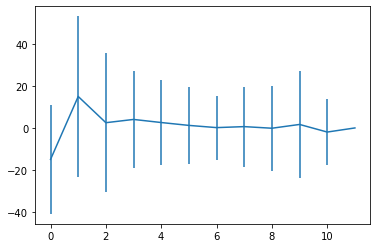

In [50]:
plt.errorbar(range(12),x[:,0],yerr=x[:,1])

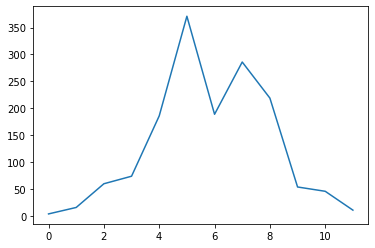

In [51]:
plt.plot(counts)

In [52]:
counts

array([  4.,  16.,  60.,  74., 186., 371., 189., 286., 219.,  54.,  46.,
        11.])

In [53]:
np.std(counts)

115.72044859151829

In [54]:
np.mean(counts)

126.33333333333333

In [55]:
(counts - np.mean(counts))/np.std(counts)

array([-1.05714534, -0.95344716, -0.5732205 , -0.45223929,  0.5156104 ,
        2.11429069,  0.54153494,  1.37976191,  0.8007804 , -0.62506959,
       -0.69420171, -0.99665474])